In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "30"

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams['font.size'] = 15

from utils.utils import *

import utils.HTC_utils as HTC
import random

import networkx as nx

import os
import seaborn as sns

cs = ['cornflowerblue', '#FEBE00']

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [140]:
def plot_results(res, res2=None, cs=['cornflowerblue', 'orange'], labels=['control', 'stroke'], lw=3):
    plt.figure(figsize=(10,3))

    ax1 = plt.subplot(1,2,1)
    ax2 = ax1.twinx()

    ax1.plot(res[0], res[1], c=cs[0], label=labels[0], lw=lw)
    ax2.plot(res[0], res[2], c=cs[0], ls='-.', lw=lw)
    
    if res2 is not None:
        ax1.plot(res2[0], res2[1], c=cs[1], label=labels[1], lw=lw)
        ax2.plot(res2[0], res2[2], c=cs[1], ls='-.', lw=lw)

    ax1.set_xlabel('T')
    ax1.set_ylabel('A')
    ax2.set_ylabel(r'$\sigma$(A)')

    ax1 = plt.subplot(1,2,2)
    ax2 = ax1.twinx()

    ax1.plot(res[0], res[3], c=cs[0], label=labels[0], lw=lw)
    ax2.plot(res[0], res[4], c=cs[0], ls='-.', lw=lw)
    
    if res2 is not None:
        ax1.plot(res2[0], res2[3], c=cs[1], label=labels[1], lw=lw)
        ax2.plot(res2[0], res2[4], c=cs[1], ls='-.', lw=lw)

    ax1.set_xlabel('T') 
    ax1.set_ylabel('S1')
    ax2.set_ylabel('S2')
    
    ax1.legend()
    plt.tight_layout()
    plt.show()

In [125]:
### Load data
ses = 1
N = 500

mats = []

data = data_loader(which='control', ses=ses, parc=N, thr='mask', include_subctx=False)
W = data.load_matrix(13)
mats.append(W)

data = data_loader(which='stroke', ses=ses, parc=N, thr='mask', include_subctx=False)
W = data.load_matrix(13)
mats.append(W)

######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
- Loading sub-055
######## stroke - ses 01 - parc 500 - total 51 - thr mask - subctx False ########
- Loading sub-222


In [1]:
### Define HTC parameters
# Rodrigo -> r1 = 2/ N; r2 = r2 ** (1/5)
# N=100 -> r1 = 1/N; r2 = 5e-1
# N=200 -> r1 = 1/N; r2 = 3e-1
# N=500 -> r1 = 1/N; r2 = 0.3
# N = 500

r1 = 1/N
r2 = 125/N

Tmin, Tmax = HTC.get_Trange(r1, r2)

steps = int(1e4)
eq_steps = int(5e3)
runs = 30
nT = 30 #nT = 30

NameError: name 'HTC' is not defined

In [143]:
r1s = [1/N]
r2s = [150/N]

params = [[r1, r2] for r1 in r1s for r2 in r2s]
print(params)

[[0.002, 0.3]]


In [132]:
ress = []

for param in params:
    r1, r2 = param
    Tmin, Tmax = HTC.get_Trange(r1, r2)

    for W in mats:
        res = HTC.run_htc(W, r1, r2, Tmin, Tmax, nT, steps, eq_steps, runs, step_clust=1,
                  norm=True, Tdiv_log=False, display=False)
        ress.append(res)

r1=0.0012, r2=0.2
Tminus=0.0011914217633042096, Tplus=0.14285714285714288
Tmin=0.0, Tmax=0.2
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 443.74s
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 

N=500
[0.0012, 0.2]


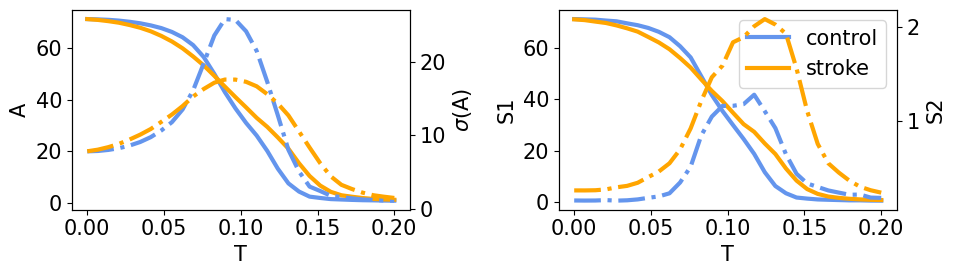

[0.0016, 0.2]


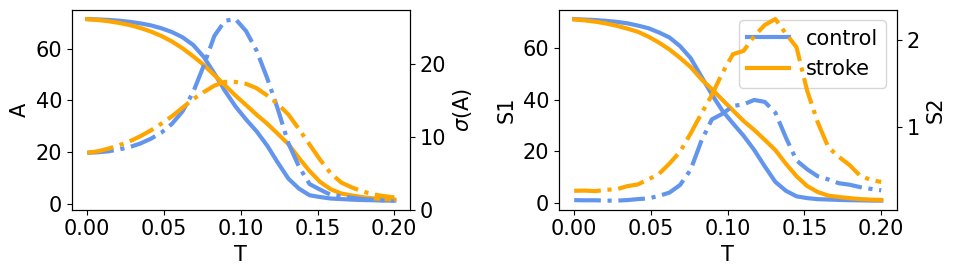

In [141]:
print(f'N={N}')
for i, param in enumerate(params):
    print(param)
    plot_results(ress[2*i], ress[2*i+1])

# Run all dataset

In [147]:
folder = 'results/criticality/'

tmp_dicts = [dict_control, dict_stroke]

steps = int(1e4)
eq_steps = int(5e3)
runs = 30
nT = 30

r2s = {100: 0.5, 200: 0.3, 500: 0.3}

for tmp_dict in tmp_dicts:
    which = tmp_dict['name']
    
    for parc in tmp_dict['parcs'][:-1]:
        for ses in tmp_dict['sessions'][:-1]:
            # Load dataset
            data = data_loader(which=which, ses=ses, parc=parc, thr='mask', include_subctx=False)
            
            for idx, mat in enumerate(data):
                # Check if connected - otherwise it has returned None
                if mat is None:
                    continue
                
                ### Define params
                r1 = 1/parc
                r2 = r2s[parc]

                Tminus = r1 * r2 / (r1 + r2 + r1*r2)
                Tplus = r2 / (2*r2 +1)

                xplus = Tplus
                yplus = Tplus / r2

                xminus = Tminus
                yminus = Tminus / r2

                Tmin = 0
                Tmax = 1.4 * Tplus
                
                # Compute HTC
                res = HTC.run_htc(mat, r1, r2, Tmin, Tmax, nT, steps, eq_steps, runs, step_clust=1,
                                  norm=True, Tdiv_log=False, display=False)
        
                # Store dimension
                np.savetxt(folder+data.full_names[idx], np.stack(res))

######## control - ses 01 - parc 100 - total 29 - thr mask - subctx False ########
- Loading sub-040
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 112.76s
- Loading sub-041
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0

9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 112.34s
- Loading sub-052
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97

21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 112.98s
- Loading sub-067
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 112.68s
- Loa

30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 254.50s
- Loading sub-045
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 252.44s
- Loading sub-046
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * 

19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 253.80s
- Loading sub-061
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating ac

End simulating activity
Total computation time: 249.50s
- Loading sub-072
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 251.86s
######## control - ses 01 - parc 500 - total 29 - thr mask - subctx False ########
- Loading sub-040
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T

7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 441.22s
- Loading sub-051
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 *

20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 439.33s
- Loading sub-066
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computati

29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 110.81s
- Loading sub-204
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 110.77s
- Loading sub-205
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 *

8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 108.10s
- Loading sub-227
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 

20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 106.69s
- Loading sub-247
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computati

2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 105.61s
- Loading sub-265
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 479.85s
- Loading sub-239
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15

13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 471.03s
- Loading sub-260
- Loading sub-261
- Loading sub-262
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
2

21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 458.97s
- Loading sub-275
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 456.75s
- Loa

23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 447.64s
- Loading sub-224
- Loading sub-228
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 452.32s
- Loading sub-229
- Loading sub

26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 468.01s
- Loading sub-266
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19 * T+
6/30 - T = 0.24 * T+
7/30 - T = 0.29 * T+
8/30 - T = 0.34 * T+
9/30 - T = 0.39 * T+
10/30 - T = 0.43 * T+
11/30 - T = 0.48 * T+
12/30 - T = 0.53 * T+
13/30 - T = 0.58 * T+
14/30 - T = 0.63 * T+
15/30 - T = 0.68 * T+
16/30 - T = 0.72 * T+
17/30 - T = 0.77 * T+
18/30 - T = 0.82 * T+
19/30 - T = 0.87 * T+
20/30 - T = 0.92 * T+
21/30 - T = 0.97 * T+
22/30 - T = 1.01 * T+
23/30 - T = 1.06 * T+
24/30 - T = 1.11 * T+
25/30 - T = 1.16 * T+
26/30 - T = 1.21 * T+
27/30 - T = 1.26 * T+
28/30 - T = 1.3 * T+
29/30 - T = 1.35 * T+
30/30 - T = 1.4 * T+
End simulating activity
Total computation time: 463.51s
- Loading sub-267
1/30 - T = 0.0 * T+
2/30 - T = 0.05 * T+
3/30 - T = 0.1 * T+
4/30 - T = 0.14 * T+
5/30 - T = 0.19

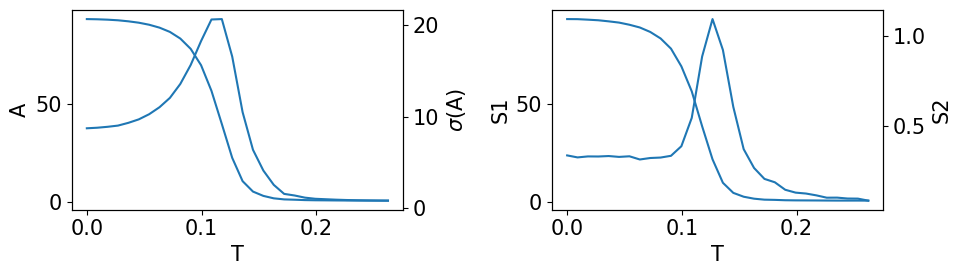

In [21]:
plot_results(res)

In [144]:
r2s = {100: 0.5, 200: 0.3, 500: 0.3}